In [1]:
import sys
sys.path.append('../') 

In [2]:
%load_ext autoreload
%autoreload 2
import sklearn
import copy
import numpy as np

import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
# from viz import viz
from bokeh.plotting import figure, show, output_notebook, output_file, save
from functions import merge_data
from sklearn.model_selection import RandomizedSearchCV
import load_data


from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from fit_and_predict import fit_and_predict

## Params:

In [3]:
aggregate_by_state = False
outcome_type = 'deaths'

## Basic Data Visualization

In [4]:
# Just something to quickly summarize the number of cases and distributions each day

In [5]:
# 'deaths' and 'cases' contain the time-series of the outbreak
df = load_data.load_county_level(data_dir = '../data/')
df = df.sort_values('#Deaths_3/28/2020', ascending=False)
# outcome_cases = load_data.outcome_cases # most recent day
# outcome_deaths = load_data.outcome_deaths
important_vars = load_data.important_keys(df)
very_important_vars = ['PopulationDensityperSqMile2010',
                       'MedicareEnrollment,AgedTot2017',
                       'PopulationEstimate2018',
                       '#ICU_beds',
                       'MedianAge2010',
                       'Smokers_Percentage',
                       'DiabetesPercentage',
                       'HeartDiseaseMortality',
                        '#Hospitals'
#                        'PopMale60-642010',
#                         'PopFmle60-642010',
#                          'PopMale65-742010',
#                          'PopFmle65-742010',
#                          'PopMale75-842010',
#                          'PopFmle75-842010',
#                          'PopMale>842010',
#                          'PopFmle>842010'
                      ]

In [6]:
def sum_lists(list_of_lists):
    arr = np.array(list(list_of_lists))
    sum_arr = np.sum(arr,0)
    return list(sum_arr)
if aggregate_by_state:
    # Aggregate by State
    state_deaths_df = df.groupby('StateNameAbbreviation').deaths.agg(sum_lists).to_frame()
    state_cases_df = df.groupby('StateNameAbbreviation').cases.agg(sum_lists).to_frame()
    df =  pd.concat([state_cases_df,state_deaths_df],axis =1 )

Number of counties with non-zero cases
1846


(array([70., 56., 26., 26., 21., 14., 13.,  9., 12., 11.,  8.,  7., 10.,
         5.,  4.,  4.,  3.,  1.,  7.,  4.,  3.,  2.,  4.,  3.,  3.,  1.,
         2.,  3.,  3.,  1.,  1.,  0.,  2.,  2.,  0.,  0.,  1.,  0.,  1.,
         1.,  1.,  0.,  1.,  1.,  0.,  0.,  1.,  1.,  1.,  0.,  1.,  0.,
         3.,  0.,  0.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  2.,  0.,
         1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
         0.,  0.,  0.,  1.,  0.,  0.,  1.,  1.,  0.,  0.,  1.,  1.,  0.,
         0.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  2.]),
 array([ 21.  ,  29.91,  38.82,  47.73,  56.64,  65.55,  74.46,  83.37,
         92.28, 101.19, 110.1 , 119.01, 127.92, 136.83, 145.74, 154.65,
        163.56, 172.47, 181.38, 190.29, 199.2 , 208.11, 217.02, 225.93,
        234.84, 243.75, 252.66, 261.57, 270.48, 279.39, 288.3 , 297.21,
        306.12, 315.03, 323.94, 332.85, 341.76, 350.67, 359.58, 368.49,
        377.4 , 386.31, 395.22, 404.13, 413.04, 421.95, 430.86, 439.77,
  

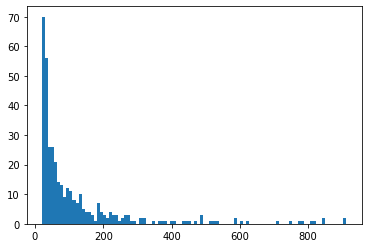

In [7]:
# Distribution of the maximum number of cases
_cases = list(df['cases'])

max_cases = []
for i in range(len(df)):
    max_cases.append(max(_cases[i]))

print('Number of counties with non-zero cases')
print(sum([v >0 for v in max_cases]))


# cases truncated below 20 and above 1000 for plot readability
plt.hist([v for v in max_cases if v > 20 and v < 1000],bins = 100)


In [8]:
sum(max_cases)

118752

In [9]:
print(sum([v > 50 for v in max_cases]))


228


In [10]:
np.quantile(max_cases,.5)

1.0

Number of counties with non-zero deaths
367


(array([31.,  6.,  4.,  4.,  2.,  2.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,
         0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,
         0.,  0.,  0.,  1.]),
 array([  6.,  13.,  20.,  27.,  34.,  41.,  48.,  55.,  62.,  69.,  76.,
         83.,  90.,  97., 104., 111., 118., 125., 132., 139., 146., 153.,
        160., 167., 174., 181., 188., 195., 202., 209., 216.]),
 <a list of 30 Patch objects>)

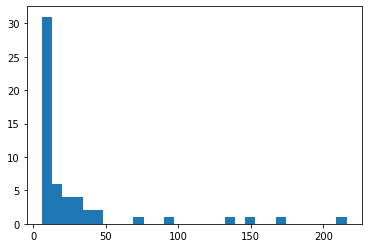

In [11]:
# Distribution of the maximum number of cases
_deaths = list(df['deaths'])

max_deaths = []
for i in range(len(df)):
    max_deaths.append(max(_deaths[i]))

print('Number of counties with non-zero deaths')
print(sum([v >0 for v in max_deaths]))
# plt.hist(max_cases)

# print(sum([v >0 for v in max_cases]))
plt.hist([v for v in max_deaths if v > 5],bins=30)

In [12]:
sum(max_deaths)

2085

In [13]:
max(max_deaths)

216

In [14]:
np.quantile(max_deaths,.7)

0.0

### Clean data

In [15]:
# Remove counties with zero cases
max_cases = [max(v) for v in df['cases']]
df['max_cases'] = max_cases
max_deaths = [max(v) for v in df['deaths']]
df['max_deaths'] = max_deaths
df =  df[df['max_cases'] > 0]



## Predict data from model:

In [48]:
# Trains model on train_df and produces predictions for the final day for test_df and writes prediction
# to a new column for test_df 
fit_and_predict(df, method='exponential', outcome=outcome_type, mode='eval_mode',target_day=[1,2,3,4])
fit_and_predict(df,method='shared_exponential', outcome=outcome_type, mode='eval_mode',target_day=[1,2,3,4])
# fit_and_predict(train_df, test_df,'shared_exponential', mode='eval_mode',demographic_vars=important_vars)
fit_and_predict( df,method='shared_exponential', outcome=outcome_type, mode='eval_mode',demographic_vars=very_important_vars,target_day=[1,2,3,4])
fit_and_predict(df, outcome=outcome_type, mode='eval_mode',
                                    method='ensemble',target_day=[1,2,3])
# fit_and_predict(train_df, test_df, method='exponential',mode='eval_mode',target_day = np.array([1,2]))

# Finds the names of all the methods
method_keys = [c for c in df if 'predicted' in c]
method_keys

Feature weights
bias : 0.9028129100105915
log(deaths) : 0.4658043303363323
Feature weights
bias : 1.9478557540420172e-05
log(deaths) : -5.238957405933739e-07
PopulationDensityperSqMile2010 : -0.001312900200705564
MedicareEnrollment,AgedTot2017 : 0.027510478780929562
#ICU_beds : -0.030159591972561746
MedianAge2010 : 0.0624833953025673
Smokers_Percentage : 0.0007735430819266875
DiabetesPercentage : 0.0482692973484611
HeartDiseaseMortality : 0.8525019156659759
#Hospitals : -0.8011402070072009
Feature weights
bias : 0.9214259382229085
log(deaths) : 0.42858521321448956
Feature weights
bias : 0.9028129100105915
log(deaths) : 0.4658043303363323
Feature weights
bias : 0.868025933226295
log(deaths) : 0.5513308367025753
Feature weights
bias : 0.8353455058469209
log(deaths) : 0.6242549547760794
Feature weights
bias : 0.9786054501591184
log(deaths) : 0.1529530928772843
Feature weights
bias : 0.9778959946505008
log(deaths) : 0.1519707624764866
Feature weights
bias : 0.956852904817589
log(deaths) : 

NameError: name 'test_df' is not defined

## Evaluate and visualize models

### Compute MSE and log MSE on relevant cases

In [19]:
# TODO: add average rank as metric

In [20]:
# Computes the mse in log space and non-log space for all columns

In [21]:
def l1(arr1,arr2):
    return sum([np.abs(a1-a2) for (a1,a2) in zip(arr1,arr2)])/len(arr1)
mse = sklearn.metrics.mean_squared_error
# Only evaluate points that exceed this number of deaths 
lower_threshold, upper_threshold = 10, 1000

In [23]:
# Log scaled
outcome = np.array([df[outcome_type].values[i][-1] for i in range(len(df))])
for key in method_keys:
    preds = [np.log(p[-1] + 1) for p in df[key][(outcome > lower_threshold) * (outcome < upper_threshold)]]
    print('Log scale MSE for '+key)
    print(mse(np.log(outcome[(outcome > lower_threshold) * (outcome < upper_threshold)] + 1),preds))

Log scale MSE for predicted_deaths_exponential_4
0.976370641194918
Log scale MSE for predicted_deaths_shared_exponential_4
0.2116821769830499
Log scale MSE for predicted_deaths_shared_exponential_4_demographics
0.36711142847288003


In [24]:
# Log scaled
outcome = np.array([df[outcome_type].values[i][-1] for i in range(len(df))])
for key in method_keys:
    preds = [np.log(p[-1] + 1) for p in df[key][outcome > lower_threshold]]
    print('Log scale l1 for '+key)
    print(l1(np.log(outcome[outcome > lower_threshold] + 1),preds))

Log scale l1 for predicted_deaths_exponential_4
0.7090922846827937
Log scale l1 for predicted_deaths_shared_exponential_4
0.38042555720875654
Log scale l1 for predicted_deaths_shared_exponential_4_demographics
0.4748880681979485


In [25]:
# No log scale
outcome = np.array([df[outcome_type].values[i][-1] for i in range(len(df))])
for key in method_keys:
    preds = [p[-1] for p in df[key][outcome > lower_threshold]]
    print('Raw MSE for '+key)
    print(mse(outcome[outcome > lower_threshold],preds))

Raw MSE for predicted_deaths_exponential_4
57932.50676309275
Raw MSE for predicted_deaths_shared_exponential_4
1565.9678058489642
Raw MSE for predicted_deaths_shared_exponential_4_demographics
2534.190111098005


In [26]:
# No log scale
outcome = np.array([df[outcome_type].values[i][-1] for i in range(len(df))])
for key in method_keys:
    preds = [p[-1] for p in df[key][outcome > lower_threshold]]
    print('Raw l1 for '+key)
    print(l1(outcome[outcome > lower_threshold],preds))

Raw l1 for predicted_deaths_exponential_4
98.40837446573506
Raw l1 for predicted_deaths_shared_exponential_4
21.562861895332006
Raw l1 for predicted_deaths_shared_exponential_4_demographics
26.262479545658888


### Plot residuals

In [27]:
# TODO: Create bounds automatically, create a plot function and call it instead of copying code, figure out way
# to plot more than two things at once cleanly

# Creates residual plots log scaled and raw
# We only look at cases with number of deaths greater than 5

/Users/nick/anaconda2/envs/covid/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


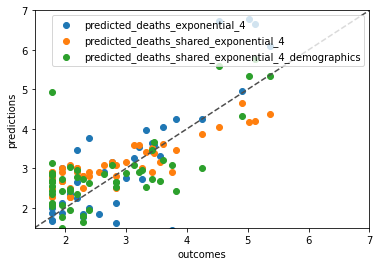

In [29]:
# Make log plots:
bounds = [1.5, 7]
outcome = np.array([df[outcome_type].values[i][-1] for i in range(len(df))])
for key in method_keys:
    preds = [np.log(p[-1]) for p in df[key][outcome > 5]]
    plt.scatter(np.log(outcome[outcome > 5]),preds,label=key)
    
plt.xlabel('outcomes')
plt.ylabel('predictions')
plt.xlim(bounds)
plt.ylim(bounds)
plt.legend()

plt.plot(bounds, bounds, ls="--", c=".3")

/Users/nick/anaconda2/envs/covid/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


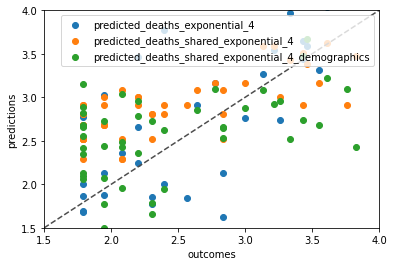

In [31]:
# Make log plots zoomed in for the counties that have a fewer number of deaths
bounds = [1.5, 4]
outcome = np.array([df['deaths'].values[i][-1] for i in range(len(df))])
for key in method_keys:
    preds = [np.log(p[-1]) for p in df[key][outcome > 5]]
    plt.scatter(np.log(outcome[outcome > 5]),preds,label=key)

plt.xlabel('outcomes')
plt.ylabel('predictions')
plt.xlim(bounds)
plt.ylim(bounds)
plt.legend()

plt.plot(bounds, bounds, ls="--", c=".3")

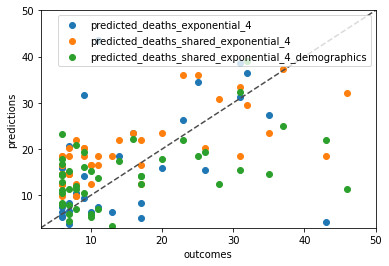

In [32]:
# Make non-log plots zoomed in for the counties that have a fewer number of deaths# We set bounds 
bounds = [3, 50]
outcome = np.array([df['deaths'].values[i][-1] for i in range(len(df))])
for key in method_keys:
    preds = [p[-1] for p in df[key][outcome > 5]]
    plt.scatter(outcome[outcome > 5],preds,label=key)

plt.xlabel('outcomes')
plt.ylabel('predictions')
plt.xlim(bounds)
plt.ylim(bounds)
plt.legend()

plt.plot(bounds, bounds, ls="--", c=".3")

### Graph Visualizations

In [33]:
# Here we visualize predictions on a per county level.
# The blue lines are the true number of deaths, and the dots are our predictions for each model for those days.

In [34]:
def plot_prediction(row):
    """
    Plots model predictions vs actual
    row: dataframe row
    window: autoregressive window size
    """
    gold_key = 'deaths'
    for i,val in enumerate(row[gold_key]):
        if val > 0:
            start_point = i
            break
    plt.plot(row[gold_key][start_point:], label=gold_key)
    
    

    for key in method_keys:
        preds = row[key]


        plt.scatter(list(range(len(row[gold_key][start_point:])))[-len(preds):],preds,label=key)
    
    plt.legend()
    plt.show()
    

Queens in NY


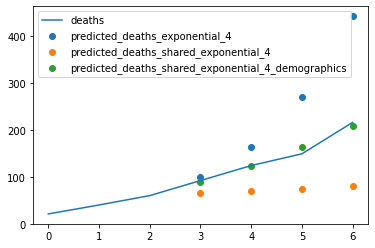

Kings in NY


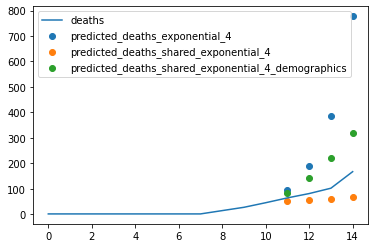

Bronx in NY


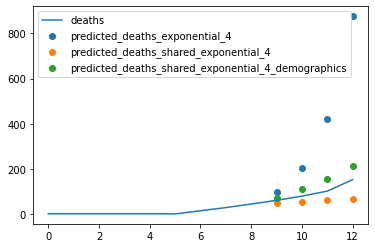

King in WA


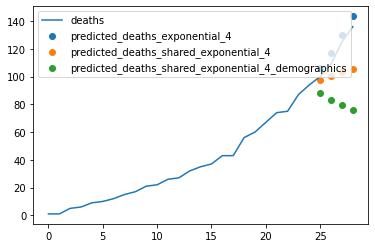

New York in NY


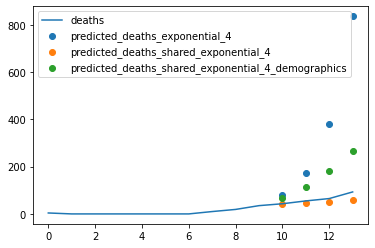

Orleans in LA


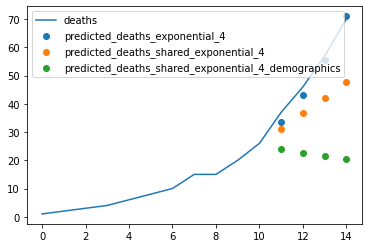

Wayne in MI


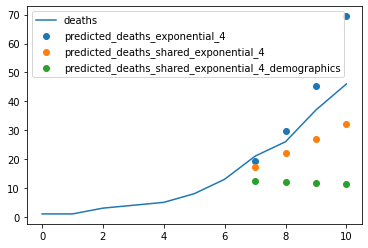

Richmond in NY


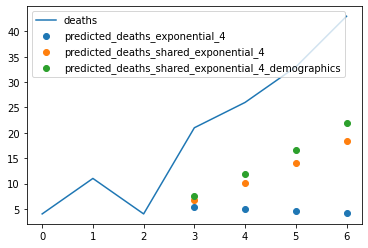

Suffolk in NY


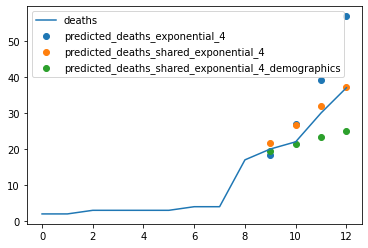

Nassau in NY


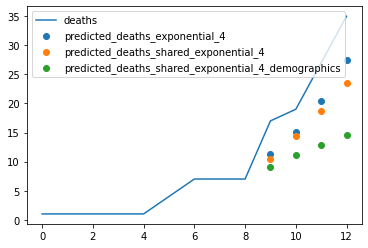

Los Angeles in CA


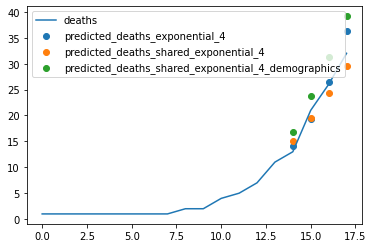

Oakland in MI


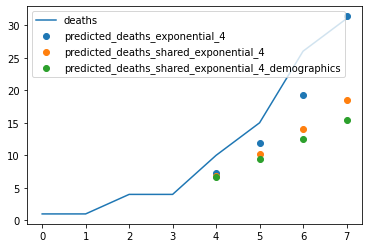

Bergen in NJ


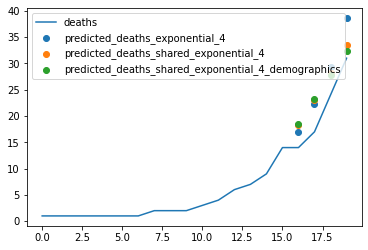

Cook in IL


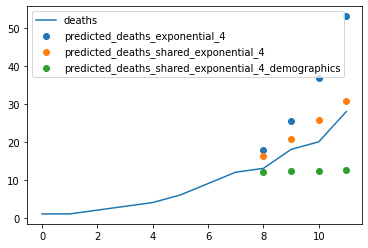

Jefferson in LA


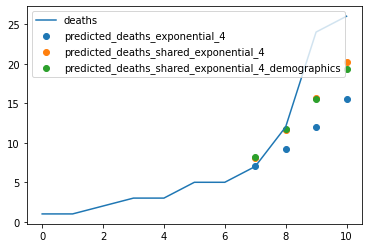

Santa Clara in CA


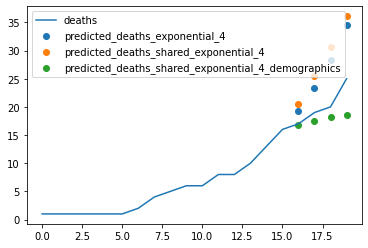

Snohomish in WA


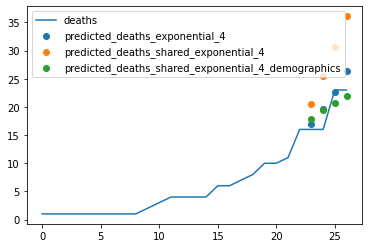

Fairfield in CT


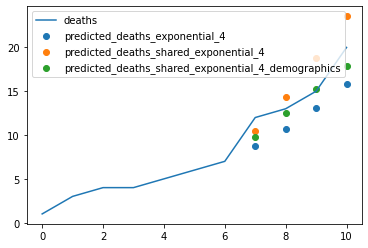

Middlesex in NJ


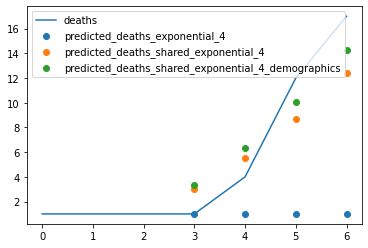

Dougherty in GA


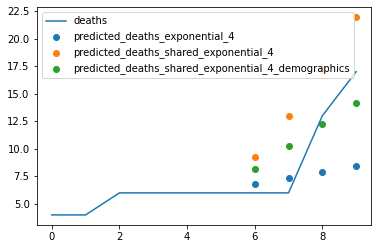

Macomb in MI


ValueError: x and y must be the same size

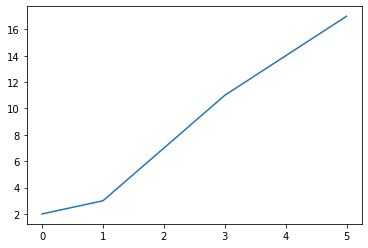

In [37]:
df = df.sort_values(by='max_deaths',ascending=False)
for i in range(len(df)):
    row = df.iloc[i]
    # If number of deaths greater than 10
    if max(row['deaths']) > 10:
        print(row['CountyName']+' in '+row['StateNameAbbreviation'])
        plot_prediction(row)